In [234]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely import geometry
from collections import Counter
import os
import json
import pandas as pd
import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm
import cv2
import pickle
from rasterio.tools.mask import mask
import seaborn as sns
import random
from rasterio.merge import merge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math

%matplotlib inline

## copernicus building data

Load shapefiles with polygons indicating various levels of building damage.

In [562]:
img_list = sorted([os.path.join('damaged_copernicus/', image_name) 
                   for image_name in os.listdir('damaged_copernicus')
                    if image_name.lower().endswith('shp')])

In [563]:
for image in img_list:
    print(image)

damaged_copernicus/EMSR058_02TACLOBANCITY_02GRADING_00OVERVIEW_v3_12500_settlements_poly_grading.shp
damaged_copernicus/EMSR058_03EASTERNSAMAR_02GRADING_00OVERVIEW_v1_20000_settlements_poly_grading.shp
damaged_copernicus/EMSR058_04PALO_02GRADING_00OVERVIEW_v2_10000_settlements_poly_grading.shp
damaged_copernicus/EMSR058_05GUIUAN_02GRADING_00OVERVIEW_v1_9000_settlements_poly_grading.shp


In [564]:
def shapefile_to_db(file_list):
    df = gpd.read_file(file_list[0])
#     print(df.shape)
    for i in range(1, len(file_list)):
        df1 = gpd.read_file(file_list[i])
        df = pd.concat([df, df1], axis = 0)
#         print(df.shape)
    return df

In [565]:
df = shapefile_to_db(img_list)

In [566]:
df.shape

(13500, 15)

In [567]:
df.grading.value_counts()

Totally Affected       10240
Highly Affected         2364
Possibly Affected        446
Moderately Affected      283
Not Affected             143
Null                      24
Name: grading, dtype: int64

In [568]:
df.geom_type.value_counts()

Polygon         13480
MultiPolygon       20
dtype: int64

In [569]:
df = df[df.geom_type == 'Polygon']

In [570]:
# consider adding in moderately damaged later
# for now only using totally affected and highly affected
collapsed = df[(df.grading == 'Totally Affected') | (df.grading == 'Highly Affected')]

In [571]:
collapsed.shape

(12587, 15)

In [572]:
# check projection
collapsed.crs

{'init': 'epsg:32651'}

In [573]:
# change projection to 4326 to match with satellite imagery geotiffs
collapsed = collapsed.to_crs({'init': 'epsg:4326'})

In [574]:
collapsed = collapsed.reset_index().drop('index', axis = 1)

In [575]:
collapsed.head()

,act_id,admin_lev,ext_date,ext_scale,functional,geometry,grading,nam,settl_acc,settl_type,source_nam,src_date,src_info,subtype,txt
0,NaN,Unknown,2013-11-10,10k,0,"POLYGON ((125.0062748193732 11.20155486464497,...",Totally Affected,Tacloban,0,Residential,Other,2013-04-07,Unk,AL020 - Built Up Area,Unk
1,NaN,Unknown,2013-11-10,10k,0,"POLYGON ((124.9996609687796 11.21659591794011,...",Totally Affected,Tacloban,0,Residential,Other,2013-04-07,Unk,AL020 - Built Up Area,Unk
2,NaN,Unknown,2013-11-10,10k,0,"POLYGON ((125.0237884819498 11.20619747042652,...",Totally Affected,Tacloban,0,Residential,Other,2013-04-07,Unk,AL020 - Built Up Area,Unk
3,NaN,Unknown,2013-11-10,10k,0,"POLYGON ((125.0232383608808 11.20611093938347,...",Totally Affected,Tacloban,0,Residential,Other,2013-04-07,Unk,AL020 - Built Up Area,Unk
4,NaN,Unknown,2013-11-10,10k,0,"POLYGON ((124.988406777381 11.23147721588609, ...",Totally Affected,Tacloban,0,Residential,Other,2013-04-07,Unk,AL020 - Built Up Area,Unk


Copernicus Emergency Management Service doesn't provide damage markings for the entire country, but rather select areas.

In [576]:
# create dataframe of bounding boxes for each shapefile
aoi_list = sorted([os.path.join('boundaries_copernicus/', image_name) 
                   for image_name in os.listdir('boundaries_copernicus')
                    if image_name.lower().endswith('shp')])

In [577]:
aoi_df = shapefile_to_db(aoi_list)

In [578]:
aoi_df = aoi_df.to_crs({'init': 'epsg:4326'}) 

In [579]:
aoi_df = aoi_df.reset_index().drop('index', axis = 1)

In [580]:
# view df to see which shapefiles are overviews and which are detailed views
aoi_df

,act_id,geometry,name,subtype
0,NaN,"POLYGON ((125.0312369167795 11.18806813657281,...",Tacloban overview,AOI
1,NaN,"POLYGON ((125.0078578591338 11.24040618538853,...",Tacloban detail,AOI
2,NaN,"POLYGON ((125.0052062273016 11.22447772324082,...",AOI,AOI
3,NaN,"POLYGON ((125.0111459493628 11.2203121334314, ...",AOI,AOI
4,NaN,"POLYGON ((125.0282163023939 11.21012708544729,...",AOI,AOI
5,NaN,"POLYGON ((125.0052062273016 11.22447772324082,...",AOITacloban detail 02,AOI
6,NaN,"POLYGON ((125.0308302938928 11.21012316644188,...",AOITacloban detail 05,AOI
7,EMSR058,"POLYGON ((125.6254956669942 11.31187014699973,...",OVR_Hernani,AOI
8,EMSR058,"POLYGON ((125.6240125439943 11.31955868299977,...",DTL01_Hernani,AOI
9,EMSR058,"POLYGON ((125.5509439839954 11.4044882869998, ...",DTL02_Hernani,AOI


In [581]:
# define bounding boxes for the four areas with have
talcoban = aoi_df.geometry[0]
samar = aoi_df.geometry[7]
palo = aoi_df.geometry[10]
guiuan = aoi_df.geometry[13]

### join satellite images for simplicity

Only need to run this section once. When geotiffs are downloaded from google earth engine, if the area of interest is large, the files get split. This section joins them back together to make it easier to crop each image according to the bounding boxes defined above.

In [582]:
def merge_tifs(files, out_file):
    sources = [rasterio.open(f) for f in files]

    out_image, out_transform = merge(sources)
    out_meta = sources[0].meta.copy()

    # save the resulting raster  
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open(out_file, "w", **out_meta) as dest:
        dest.write(out_image)  

In [583]:
pre_ps_img_list = sorted([os.path.join('/mnt/pan/', image_name) 
                   for image_name in os.listdir('/mnt/pan/') 
                   if image_name.lower().endswith('tif') and
                   image_name.lower().startswith('pre')])

post_ps_img_list = sorted([os.path.join('/mnt/pan/', image_name) 
                   for image_name in os.listdir('/mnt/pan/') 
                   if image_name.lower().endswith('tif') and
                   image_name.lower().startswith('post')])

pre_n_img_list = sorted([os.path.join('/mnt/non-pan/', image_name) 
                   for image_name in os.listdir('/mnt/non-pan/') 
                   if image_name.lower().endswith('tif') and
                   image_name.lower().startswith('pre')])

post_n_img_list = sorted([os.path.join('/mnt/non-pan/', image_name) 
                   for image_name in os.listdir('/mnt/non-pan/') 
                   if image_name.lower().endswith('tif') and
                   image_name.lower().startswith('post')])

merge_tifs(pre_ps_img_list, '/mnt/merged_images/PRE_pan_sharp.tif')
merge_tifs(post_ps_img_list, '/mnt/merged_images/POST_pan_sharp.tif')
merge_tifs(pre_n_img_list, '/mnt/merged_images/PRE_non_pan.tif')
merge_tifs(post_n_img_list, '/mnt/merged_images/POST_non_pan.tif')

### intersection with images: crop and generate masks

This section crops the geotiffs according to the bounding box for each area of interest. It then finds the intersection of the damaged building polygons with the satellite image and creates a pixel mask of 0s and 1s, with 1s indicating the pixel is part of a damaged building.

In [584]:
def crop_images(coordinates, image_dir_path, img_out_path, series):

    img_list = [os.path.join(image_dir_path, image_name) 
                   for image_name in os.listdir(image_dir_path) 
                   if image_name.lower().endswith('tif')]

    image_names = [image_name[:-4] for image_name in os.listdir(image_dir_path) if image_name.lower().endswith('tif')]

    i = 0
    for image in img_list:
        geom = [{'type': 'Polygon', 'coordinates': [coordinates]}]

        with rasterio.open(image) as src:
            out_image, out_transform = mask(src, geom, crop = True)
        out_meta = src.meta.copy()

        # save the resulting raster  
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

        with rasterio.open(img_out_path + image_names[i] + '_crop_' + str(series) + '.tif', "w", **out_meta) as dest:
            dest.write(out_image)  
        i +=1

In [585]:
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

In [586]:
def generate_masks(image_path, building_polygon_df):
    
    def make_mask_from_many(img_shape, poly_list):
        """Make a mask from multiple polygons"""
        poly_pts = [polycoords(poly) for poly in coord_list if poly]
        # note: deal with rounding here??
        polys = [[x.astype(int) for x in j] for j in poly_pts]
        polys = [np.asarray(poly) for poly in polys]
        # Create an empty mask and then fill in the polygons
        mask = np.zeros(img_shape[:2])
        cv2.fillPoly(mask, polys, 1)
        return mask.astype('uint8')

    # create mask for given image

    src = rasterio.open(image_path)
    img = src.read().transpose([1,2,0])
    img_bounds = shapely.geometry.box(*src.bounds)
    img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])

    coord_list = []
    
    for poly in collapsed.geometry:

        mask_poly = poly.intersection(img_bounds)
        mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)
        coord_list.append(mask_poly_pxcoords)
            
    mask = make_mask_from_many(img.shape, coord_list)
    # removing first row which is a border (remnant of cropping)
    mask = mask[1:, :]

    return mask

In [587]:
# crop talcoban city
coords = list(talcoban.boundary.coords)

images_in = '/mnt/merged_images/'
imgages_out = '/mnt/cropped_images/'
crop_images(coords, images_in, imgages_out, 1)

In [641]:
# print(talcoban.centroid)

In [588]:
# samar
coords = list(samar.boundary.coords)

images_in = '/mnt/merged_images/'
imgages_out = '/mnt/cropped_images/'
crop_images(coords, images_in, imgages_out, 2)

In [589]:
# palo
coords = list(palo.boundary.coords)

images_in = '/mnt/merged_images/'
imgages_out = '/mnt/cropped_images/'
crop_images(coords, images_in, imgages_out, 3)

In [642]:
print(palo.centroid)

POINT (124.9976464117409 11.16318053505171)


In [590]:
# guiuan
coords = list(guiuan.boundary.coords)

images_in = '/mnt/merged_images/'
imgages_out = '/mnt/cropped_images/'
crop_images(coords, images_in, imgages_out, 4)

In [591]:
# generate masks from cropped sharpened post image
image_in = '/mnt/cropped_images/POST_pan_sharp_crop_1.tif'
mask1 = generate_masks(image_in, collapsed)
image_in = '/mnt/cropped_images/POST_pan_sharp_crop_2.tif'
mask2 = generate_masks(image_in, collapsed)
image_in = '/mnt/cropped_images/POST_pan_sharp_crop_3.tif'
mask3 = generate_masks(image_in, collapsed)
image_in = '/mnt/cropped_images/POST_pan_sharp_crop_4.tif'
mask4 = generate_masks(image_in, collapsed)

**a few checks:**

Checks confirm mask shapes are reasonable and that masks have nonzero values.

In [592]:
mask1.shape

(498, 327)

In [593]:
np.nonzero(mask1)

(array([  3,   3,   4, ..., 497, 497, 497]),
 array([ 23,  24,  22, ..., 125, 126, 127]))

In [594]:
mask2.shape

(785, 660)

In [595]:
# np.nonzero(mask2)

In [596]:
mask3.shape

(361, 409)

In [597]:
np.nonzero(mask3)

(array([  0,   0,   0, ..., 360, 360, 360]),
 array([170, 171, 173, ..., 263, 269, 270]))

In [598]:
mask4.shape

(255, 390)

In [599]:
np.nonzero(mask4)

(array([  0,   0,   0, ..., 241, 241, 241]),
 array([ 40,  41,  42, ..., 257, 259, 260]))

In [600]:
# percent of nonzeros for mask1
len(np.nonzero(mask1)[0]) / (len(mask1[0])*len(mask1[1])) * 100

34.687502922499974

In [601]:
# percent of nonzeros for mask2
len(np.nonzero(mask2)[0]) / (len(mask2[0])*len(mask2[1])) * 100

0.1753902662993572

In [602]:
# percent of nonzeros for mask3
len(np.nonzero(mask3)[0]) / (len(mask3[0])*len(mask3[1])) * 100

7.700814796659514

In [603]:
# percent of nonzeros for mask4
len(np.nonzero(mask4)[0]) / (len(mask4[0])*len(mask4[1])) * 100

4.725180802103878

## stack and prep for unet

This section reads in the satellite images and stacks the pre-typhoon band values, post-typhoon band values, and the subraction values. Both pan sharpened band values and non pan sharpened band information is used. Values are normalized to be between 0 and 1. These matrices are the features for the model.

In [604]:
def stack_images(image_dir_path, series):
    
    img_list = sorted([os.path.join(image_dir_path, image_name) 
                   for image_name in os.listdir(image_dir_path) 
                   if image_name.lower().endswith(str(series) + '.tif')], reverse = True)
    
    srcs = [rasterio.open(f) for f in img_list]
    
    unstacked_imgs = [src.read().transpose([1,2,0]) for src in srcs]
    
    # concatenating pan and nonpan for pre and post
    # removing first row which is all zeroes (remnant from cropping earlier)
    pre_typhoon = np.dstack((unstacked_imgs[0][1:, :, :], unstacked_imgs[1][1:, :, :]))
    post_typhoon = np.dstack((unstacked_imgs[2][1:, :, :], unstacked_imgs[3][1:, :, :]))
    subtraction = np.subtract(post_typhoon, pre_typhoon)
    
    pre_post = np.dstack((pre_typhoon, post_typhoon))
    stacked_image = np.dstack((pre_post, subtraction))
    
    return stacked_image

In [605]:
def reshape_and_normalize(stacked, mask):
    
    shape0 = stacked.shape[0]//32 * 32
    shape1 = stacked.shape[1]//32 * 32
    
    # get both to a shape divisible by 32
    stacked = stacked[:shape0, :shape1, :]
    mask = mask[:shape0, :shape1]
    
    # rescale all numbers between 0 and 1
    stacked = stacked.astype('float32')
    for i in range(stacked.shape[2]):
        stacked[:, :, i] = (stacked[:, :, i] - stacked[:, :, i].min())/ \
                                    (stacked[:, :, i].max() - stacked[:, :, i].min())

    return stacked, mask

## balanced

I create a balanced sample with equal amounts of damaged and non-damaged buildings in my training and validation sets. This makes the model more sensitive to damaged buildings.

In [627]:
def crop32_balance_and_split(stacked_list, mask_list):
    """
    Takes in a list of stacked images and a list of corresponding masks. Crops each into 32 x 32 pixel squares.
    Rotates images and masks with building damage (i.e. nonzero) to create additional training data. Divies up 70% of 
    nonzero and zero images and masks into training data and remaining 30% into validation.
    """
    
    i = 0
    
    for x in range(len(stacked_list)):
        stacked = stacked_list[x]
        mask = mask_list[x]
    
        k = 0
        j = 0
        z = 0
        masks = []
        imgs = []
        nonzero_indices = []
        zero_indices = []
        for k in range(0, stacked.shape[0], 32):
            for j in range(0, stacked.shape[1], 32):
                m = mask[k:k+32, j:j+32]
                image = stacked[k:k+32, j:j+32, :]
                masks.append(m)
                imgs.append(image)
                # if np.sum(m) > 0:
                # make this more sensitive to collapsed
                if np.sum(m) > 10:
                    nonzero_indices.append(z)
                else:
                    zero_indices.append(z)
                z +=1


        nonzero_masks = [masks[i] for i in nonzero_indices]

        # rotate nonzero masks
        rotated_nonzero_masks = [np.rot90(m) for m in nonzero_masks] + [np.rot90(m, 2) for m in nonzero_masks] + \
                                    [np.rot90(m, 3) for m in nonzero_masks]
        nonzero_masks.extend(rotated_nonzero_masks)
        
        zero_masks = [masks[i] for i in zero_indices]
        # rotate zero masks
#         rotated_zero_masks = [np.rot90(m) for m in zero_masks] + [np.rot90(m, 2) for m in zero_masks] + \
#                                 [np.rot90(m, 3) for m in zero_masks]
#         zero_masks.extend(rotated_zero_masks)

        
        nonzero_imgs = [imgs[i] for i in nonzero_indices]
        # rotate nonzero images
        rotated_nonzero_imgs = [np.rot90(m) for m in nonzero_imgs] + [np.rot90(m, 2) for m in nonzero_imgs] + \
                                    [np.rot90(m, 3) for m in nonzero_imgs]
        nonzero_imgs.extend(rotated_nonzero_imgs)
        
        zero_imgs = [imgs[i] for i in zero_indices]
        # rotate zero masks
#         rotated_zero_imgs = [np.rot90(m) for m in zero_imgs] + [np.rot90(m, 2) for m in zero_imgs] + \
#                                 [np.rot90(m, 3) for m in zero_imgs]
#         zero_imgs.extend(rotated_zero_imgs)


        # split up nonzero imgs

        random.seed(10)
        indices = np.arange(len(nonzero_masks))
        random.shuffle(indices)

        
        # first 70% of shuffled into train
        p70 = int(.7*len(indices))

        # 70% in train
        for num in indices[:p70]:
            img_num = i
            np.save('train/masks/nonzero/' + str(img_num), nonzero_masks[num])
            np.save('train/imgs/nonzero/' + str(img_num), nonzero_imgs[num])
            i +=1

        # 30% in test
        for num in indices[p70:]:
            img_num = i
            np.save('validation/masks/nonzero/' + str(img_num), nonzero_masks[num])
            np.save('validation/imgs/nonzero/' + str(img_num), nonzero_imgs[num])
            i +=1

        # split up zero images

        random.seed(10)
        indices = np.arange(len(zero_masks))
        random.shuffle(indices)


        # first 70% of shuffled into train
        p70 = int(.7*len(indices))

        # 70% in train
        for num in indices[:p70]:
            img_num = i
            np.save('train/masks/zero/' + str(img_num), zero_masks[num])
            np.save('train/imgs/zero/' + str(img_num), zero_imgs[num])
            i +=1

        # 30% in test
        for num in indices[p70:]:
            img_num = i
            np.save('validation/masks/zero/' + str(img_num), zero_masks[num])
            np.save('validation/imgs/zero/' + str(img_num), zero_imgs[num])
            i +=1

    # return masks, imgs

In [628]:
# crop holdout images into 32 x 32 squares and save into zero and nonzero folders
def crop32_holdout_split(stacked_list, mask_list):
    
    i = 0
    
    for x in range(len(stacked_list)):
        stacked = stacked_list[x]
        mask = mask_list[x]
    
        k = 0
        j = 0
        z = 0
        masks = []
        imgs = []
        nonzero_indices = []
        zero_indices = []
        for k in range(0, stacked.shape[0], 32):
            for j in range(0, stacked.shape[1], 32):
                m = mask[k:k+32, j:j+32]
                image = stacked[k:k+32, j:j+32, :]
                masks.append(m)
                imgs.append(image)
                if np.sum(m) > 0:
                # make this more sensitive to collapsed
                # if np.sum(m) > 10:
                    nonzero_indices.append(z)
                else:
                    zero_indices.append(z)
                z +=1



        nonzero_masks = [masks[i] for i in nonzero_indices]
        zero_masks = [masks[i] for i in zero_indices]

        nonzero_imgs = [imgs[i] for i in nonzero_indices]
        zero_imgs = [imgs[i] for i in zero_indices]

        # split up nonzero imgs and masks

        # this shuffle is optional
        random.seed(10)
        nonzero_indices = np.arange(len(nonzero_masks))
        random.shuffle(nonzero_indices)

        for num in nonzero_indices:
            img_num = i
            np.save('holdout/masks/nonzero/' + str(img_num), nonzero_masks[num])
            np.save('holdout/imgs/nonzero/' + str(img_num), nonzero_imgs[num])
            i +=1


        # split up zero images and masks

        # this shuffle is optional
        random.seed(10)
        zero_indices = np.arange(len(zero_masks))
        random.shuffle(zero_indices)

        for num in zero_indices:
            img_num = i
            np.save('holdout/masks/zero/' + str(img_num), zero_masks[num])
            np.save('holdout/imgs/zero/' + str(img_num), zero_imgs[num])
            i +=1

    return masks, imgs

In [629]:
cropped_images = '/mnt/cropped_images/'
stacked_image1 = stack_images(cropped_images, 1)
stacked_image2 = stack_images(cropped_images, 2)
stacked_image3 = stack_images(cropped_images, 3)
stacked_image4 = stack_images(cropped_images, 4)

In [630]:
# clear inventory of images

% rm train/imgs/zero/*
% rm train/imgs/nonzero/*
% rm train/masks/zero/*
% rm train/masks/nonzero/*
% rm validation/imgs/zero/*
% rm validation/imgs/nonzero/*
% rm validation/masks/zero/*
% rm validation/masks/nonzero/*
% rm holdout/imgs/zero/*
% rm holdout/imgs/nonzero/*
% rm holdout/masks/zero/*
% rm holdout/masks/nonzero/*

In [631]:
stacked_image1, mask1 = reshape_and_normalize(stacked_image1, mask1)
stacked_image2, mask2 = reshape_and_normalize(stacked_image2, mask2)
stacked_image3, mask3 = reshape_and_normalize(stacked_image3, mask3)
stacked_image4, mask4 = reshape_and_normalize(stacked_image4, mask4)

In [632]:
# crop32_balance_and_split([stacked_image1], [mask1])

In [633]:
# crop32_balance_and_split([stacked_image1, stacked_image2], [mask1, mask2])

In [634]:
crop32_balance_and_split([stacked_image1, stacked_image2, stacked_image4], [mask1, mask2, mask4])

In [635]:
holdout_masks, holdout_imgs = crop32_holdout_split([stacked_image3], [mask3])

### save for later

In [420]:
np.save('stacked_imgs_masks/stacked_image1', stacked_image1)
np.save('stacked_imgs_masks/stacked_image2', stacked_image2)
np.save('stacked_imgs_masks/stacked_image3', stacked_image3)
np.save('stacked_imgs_masks/stacked_image4', stacked_image4)
np.save('stacked_imgs_masks/mask1', mask1)
np.save('stacked_imgs_masks/mask2', mask2)
np.save('stacked_imgs_masks/mask3', mask3)
np.save('stacked_imgs_masks/mask4', mask4)

In [636]:
np.save('holdout_masks', holdout_masks)
np.save('holdout_imgs', holdout_imgs)

## exploration: view masks and satellite images

In [ ]:
# black areas demarcate damaged buildings

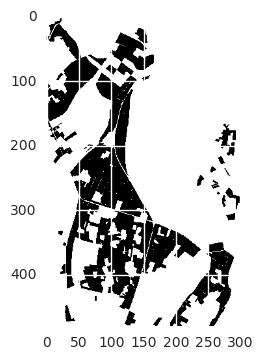

In [198]:
plt.imshow(mask1)

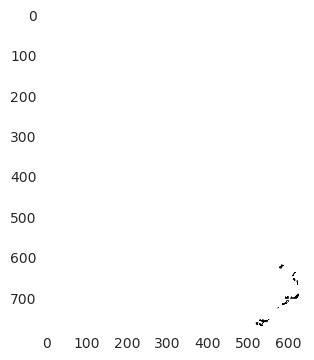

In [199]:
plt.imshow(mask2)

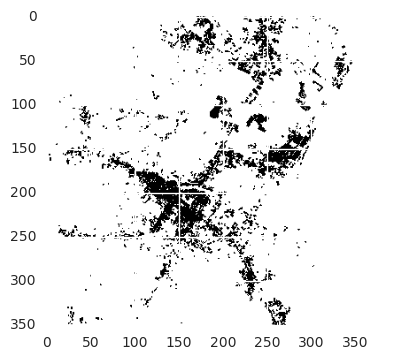

In [200]:
plt.imshow(mask3)

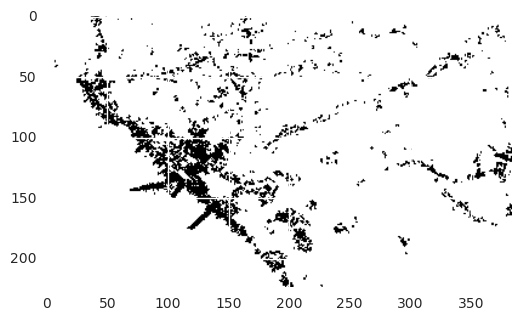

In [201]:
plt.imshow(mask4)

In [211]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        # ignore NaN values
        lower, upper = np.nanpercentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

In [405]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [406]:
src = rasterio.open('/mnt/cropped_images/POST_pan_sharp_crop_1.tif')
#src = rasterio.open('../geo/cropped/cropped_pre-typhoon_43260000000000-0000000000.tif')
img = src.read().transpose([1,2,0])

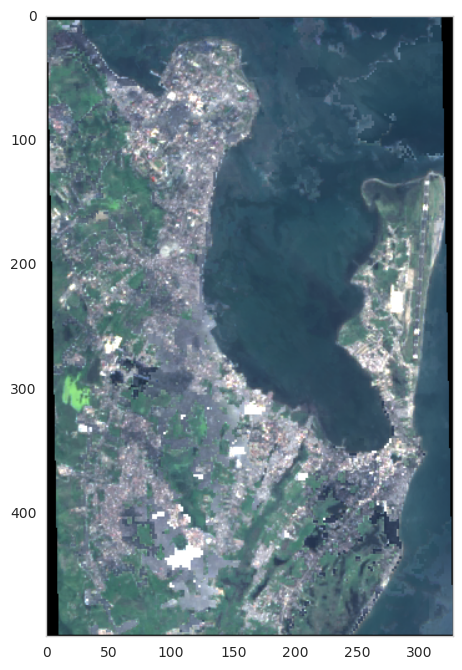

In [407]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))

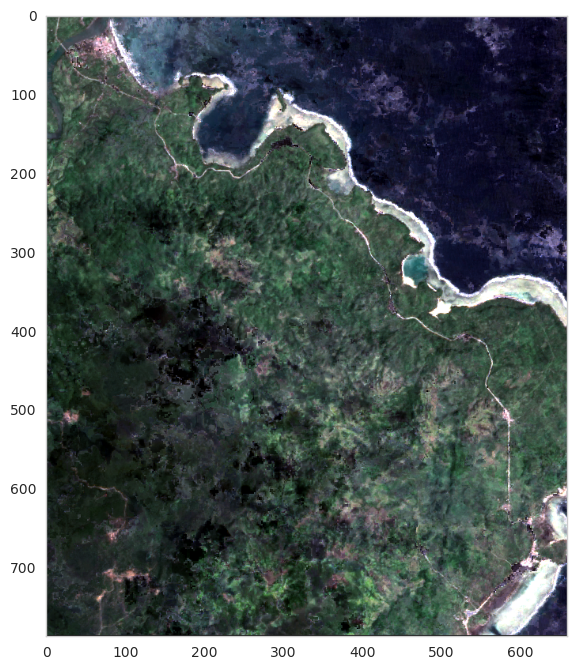

In [408]:
src = rasterio.open('/mnt/cropped_images/POST_pan_sharp_crop_2.tif')
img = src.read().transpose([1,2,0])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))

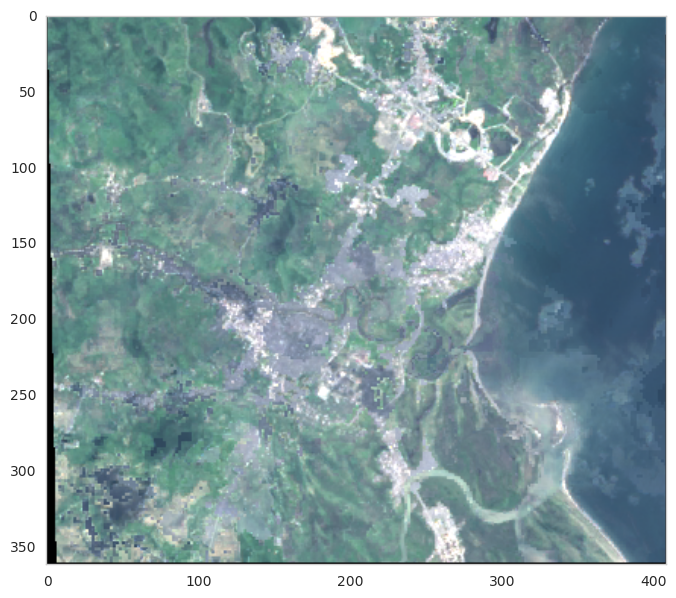

In [409]:
src = rasterio.open('/mnt/cropped_images/POST_pan_sharp_crop_3.tif')
img = src.read().transpose([1,2,0])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))

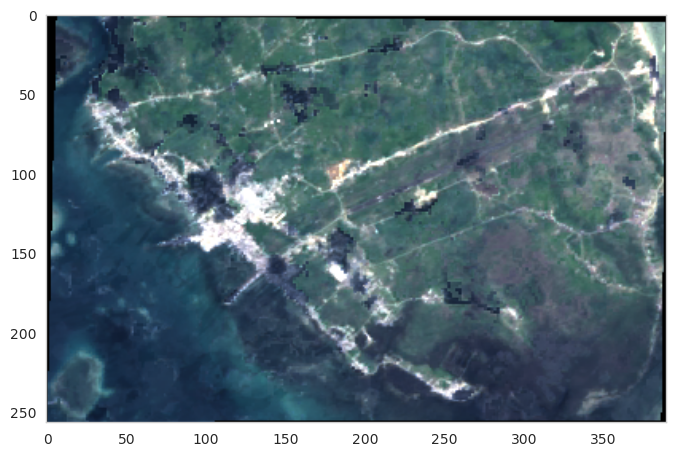

In [410]:
src = rasterio.open('/mnt/cropped_images/POST_pan_sharp_crop_4.tif')
img = src.read().transpose([1,2,0])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))